In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from utils import span

In [48]:
def rename_cols(s):
    new_name = (s
        .lower()
        .replace(' ', '_')
        .replace('[', '')
        .replace(']', '')
        .replace('/', '_')
        .replace('relative_humidity_%', 'hum')
        #.replace('%','perc')
        .replace('_kw', '_kW')
        .replace('_w', '_W')
        .replace('prediction', 'pred')
        #.replace('relative', 'rel')
        .replace('temperature_c', 'temp')
        #.replace('humidity', 'hum')
        .replace('radiation_', '')
        .replace('drybulb_', '')
        .replace('_status', '')
        .replace('6h_pred', 'pred_6h')
        .replace('12h_pred', 'pred_12h')
        .replace('24h_pred', 'pred_24h')
        .replace('average_unmet_cooling_setpoint_difference_c', 'avg_unmet_cooling_temp') #do we even need this column?
    )
    return new_name #re.sub(r'_c$', '', new_name)

In [54]:
building_nr = 4

#1. load json for this building
with open("../data/citylearn_challenge_2021/schema.json") as schema_file:
    schema = json.load(schema_file)

building_properties = schema['buildings'][f'Building_{building_nr}']
pv_nominal_power_kW = building_properties['pv']['attributes']['nominal_power']

weather = pd.read_csv("../data/citylearn_challenge_2021/weather.csv")
building = pd.read_csv("../data/citylearn_challenge_2021/Building_5.csv")
building = pd.concat([building, weather], axis=1)
assert len(building) == len(weather)

building = (building
.drop(columns=["Heating Load [kWh]"])
.assign(
        datetime = span('2008-01-02', '2011-12-31'),
        holiday = lambda x: x["Day Type"] == 8)
.assign(workday = lambda x: (x.datetime.dt.weekday >= 1) & (x.datetime.dt.weekday <= 5) & (x["Day Type"] != 8) )
#.drop(columns=["Month", "Hour", "Day Type"])
.drop(columns=["Hour", "Day Type"])
.set_index("datetime")
.rename(columns=rename_cols)
.assign(solar_generation_kW = lambda x: x.solar_generation_W_kW * pv_nominal_power_kW/1000)
)
building.columns

Index(['month', 'daylight_savings', 'indoor_temp', 'avg_unmet_cooling_temp',
       'indoor_hum', 'equipment_electric_power_kWh', 'dhw_heating_kWh',
       'cooling_load_kWh', 'solar_generation_W_kW', 'outdoor_temp',
       'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2',
       'pred_6h_outdoor_temp', 'pred_12h_outdoor_temp',
       'pred_24h_outdoor_temp', 'pred_6h_outdoor_hum', 'pred_12h_outdoor_hum',
       'pred_24h_outdoor_hum', 'pred_6h_diffuse_solar_W_m2',
       'pred_12h_diffuse_solar_W_m2', 'pred_24h_diffuse_solar_W_m2',
       'pred_6h_direct_solar_W_m2', 'pred_12h_direct_solar_W_m2',
       'pred_24h_direct_solar_W_m2', 'holiday', 'workday',
       'solar_generation_kW'],
      dtype='object')

Text(0.5, 1.0, 'Direct solar radiation [W/m2]')

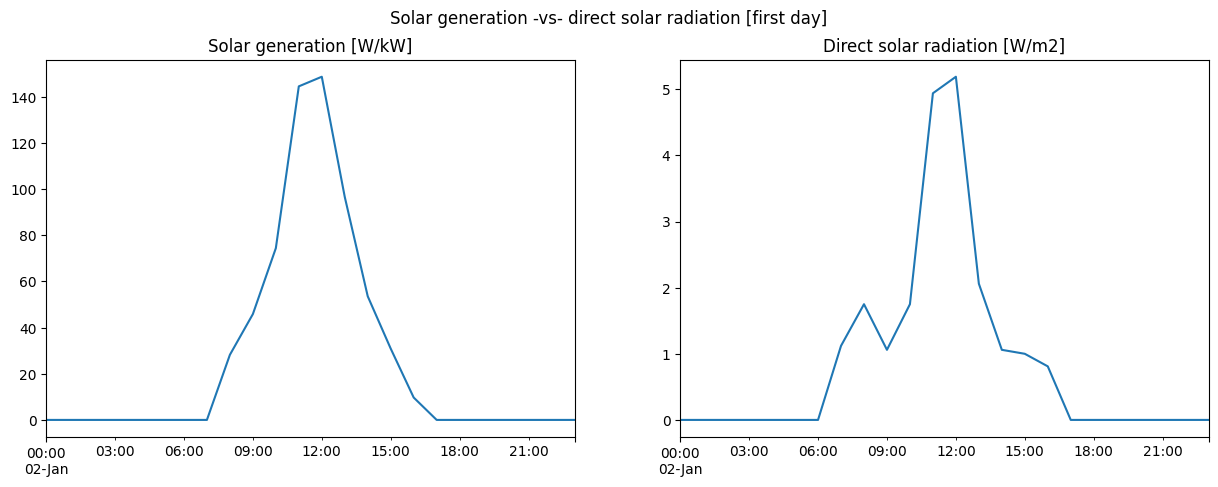

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Solar generation -vs- direct solar radiation [first day]")
b5.loc[span('2008-01-02'), 'solar_generation_W_kW'].plot(ax=ax1) #7 = Solar Generation [W/kW]
ax1.set_title("Solar generation [W/kW]")
b5.loc[span('2008-01-02'), 'direct_solar_radiation_W_m2'].plot(ax=ax2);
ax2.set_title("Direct solar radiation [W/m2]")

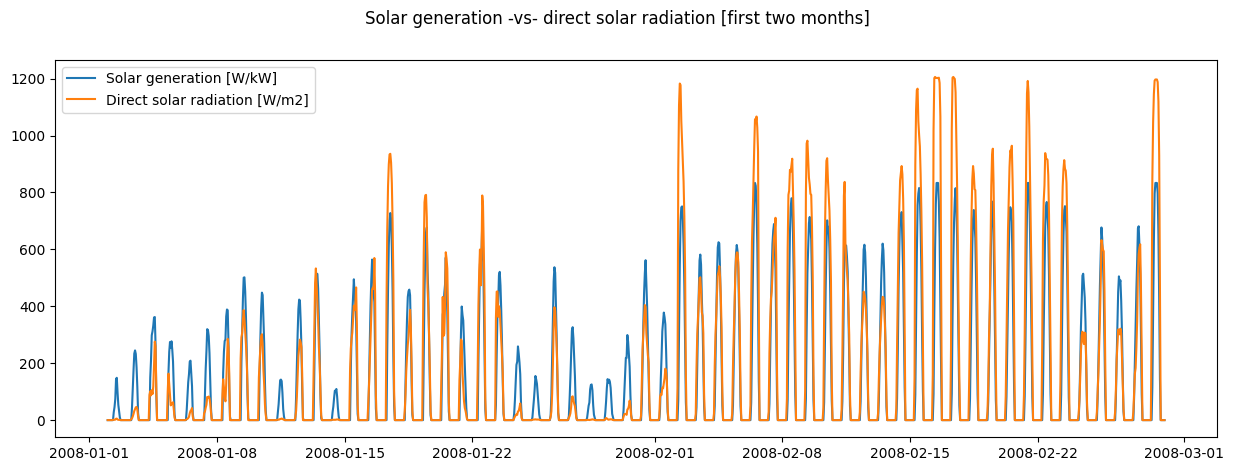

In [20]:
fig, ax = plt.subplots()
fig.suptitle("Solar generation -vs- direct solar radiation [first two months]")
ax.plot('solar_generation_W_kW', data=b5.loc[span('2008-01-02', '2008-02-28'), :], label="Solar generation [W/kW]")
ax.plot('direct_solar_radiation_W_m2', data=b5.loc[span('2008-01-02', '2008-02-28'), :], label="Direct solar radiation [W/m2]")
plt.legend()

# Trends and Seasonalities

In [7]:
import seaborn as sns
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [8]:
def plot_decomposition(decomposition):
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
    decomposition.observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title='Actual temperature')
    decomposition.trend.plot(c=sns_c[1], ax=ax[1])
    ax[1].set(title='trend')
    decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
    ax[2].set(title='seasonal')
    decomposition.resid.plot(c=sns_c[3], ax=ax[3])
    ax[3].set(title='residual')
    fig.set_size_inches(20, 10);

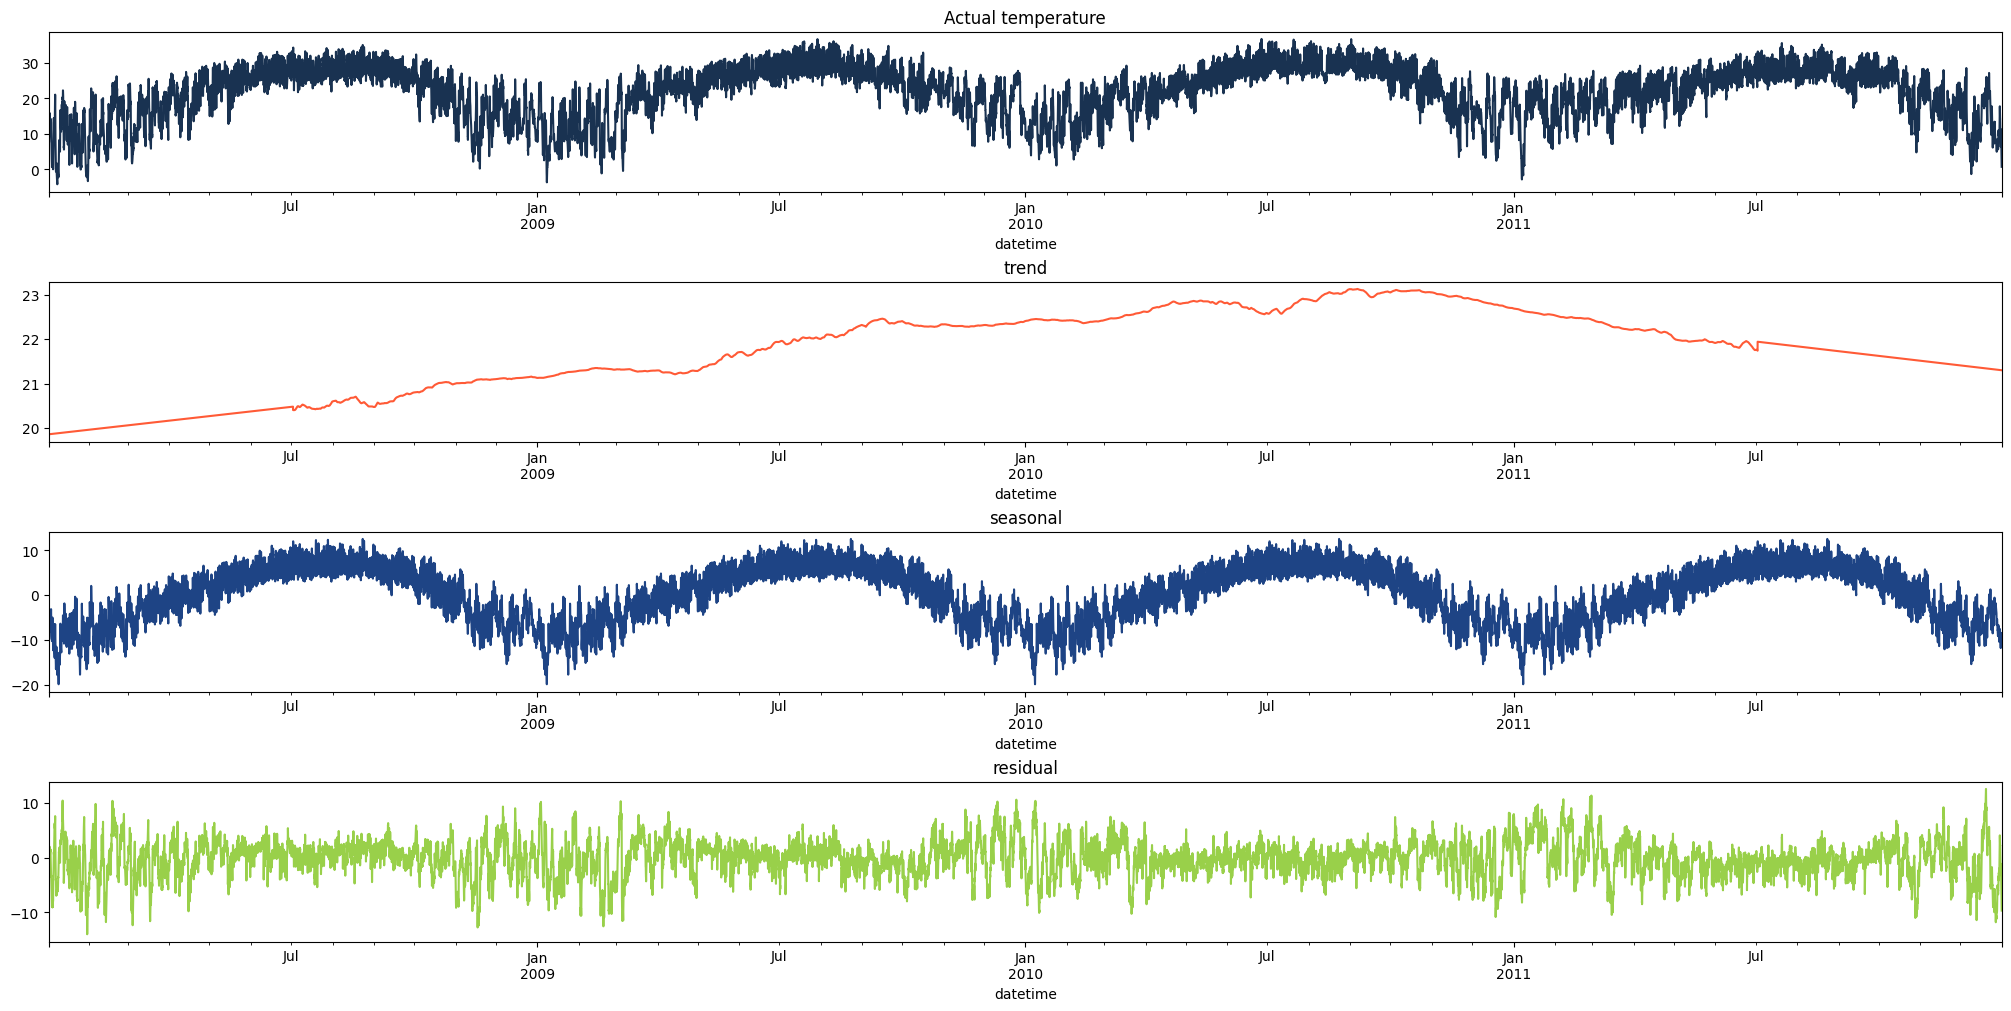

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

orig_data = b5.outdoor_drybulb_temp_C 
decomposition_yearlyseason = seasonal_decompose(x=orig_data,
                                   model='additive',
                                   period=365*24, extrapolate_trend='freq')
plot_decomposition(decomposition_yearlyseason)

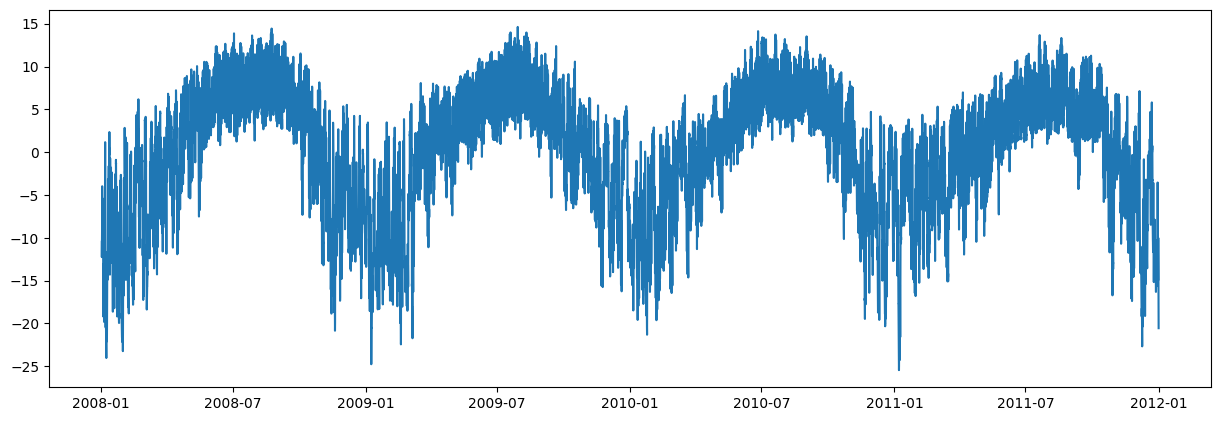

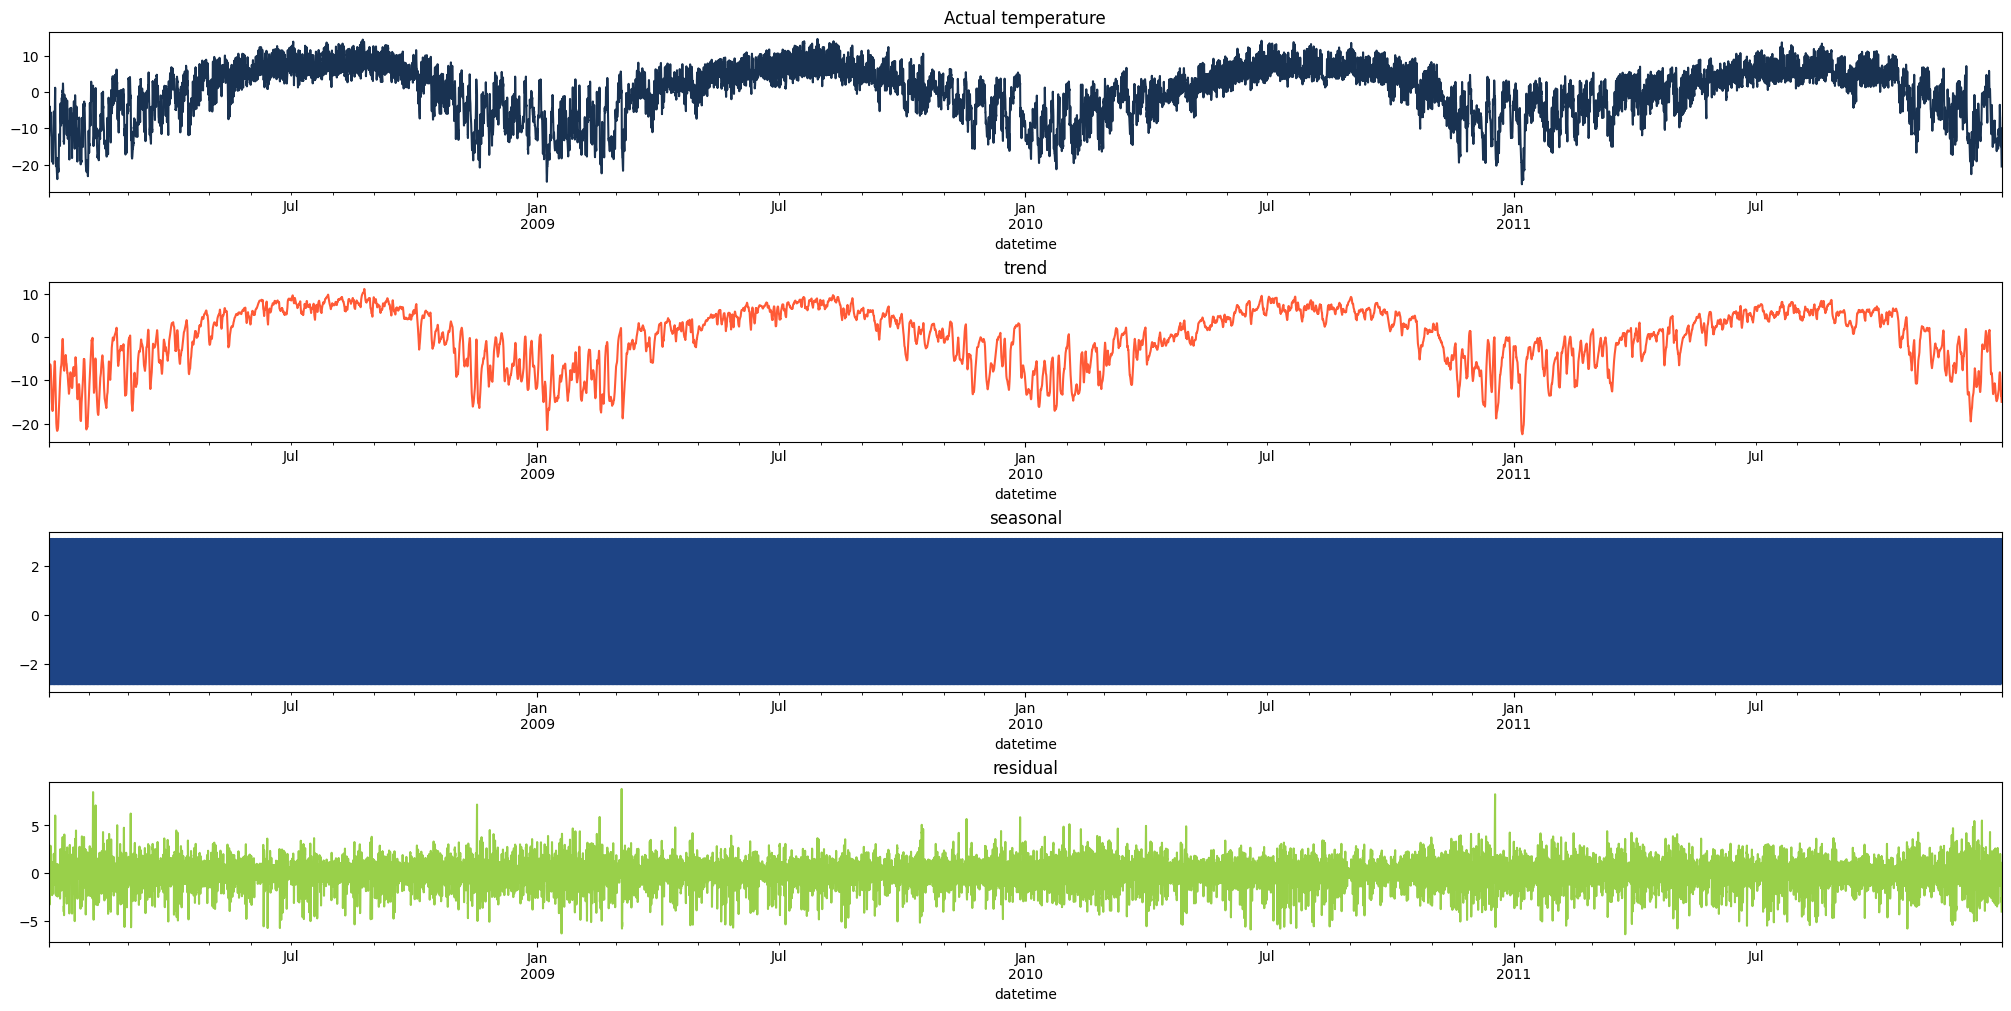

In [10]:
year_clean_data = orig_data - decomposition_yearlyseason.trend

plt.plot(year_clean_data)
decomposition_yearlydailyseason = seasonal_decompose(x=year_clean_data,
                                   model='additive',
                                   period=24, extrapolate_trend='freq')
plot_decomposition(decomposition_yearlydailyseason)

<AxesSubplot:xlabel='datetime'>

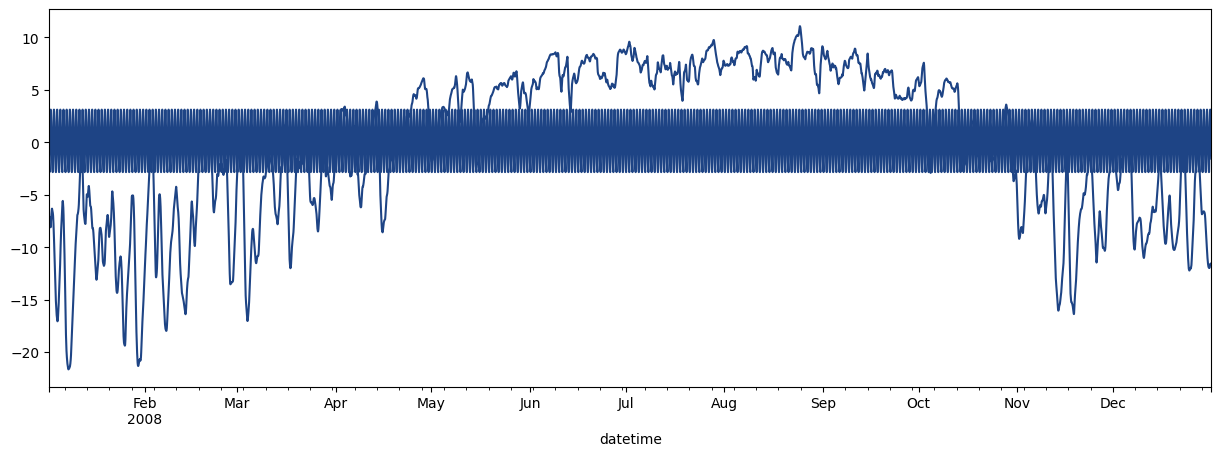

In [11]:
decomposition_yearlydailyseason.seasonal.head(365*24).plot(c=sns_c[2])
decomposition_yearlydailyseason.trend.head(365*24).plot(c=sns_c[2])

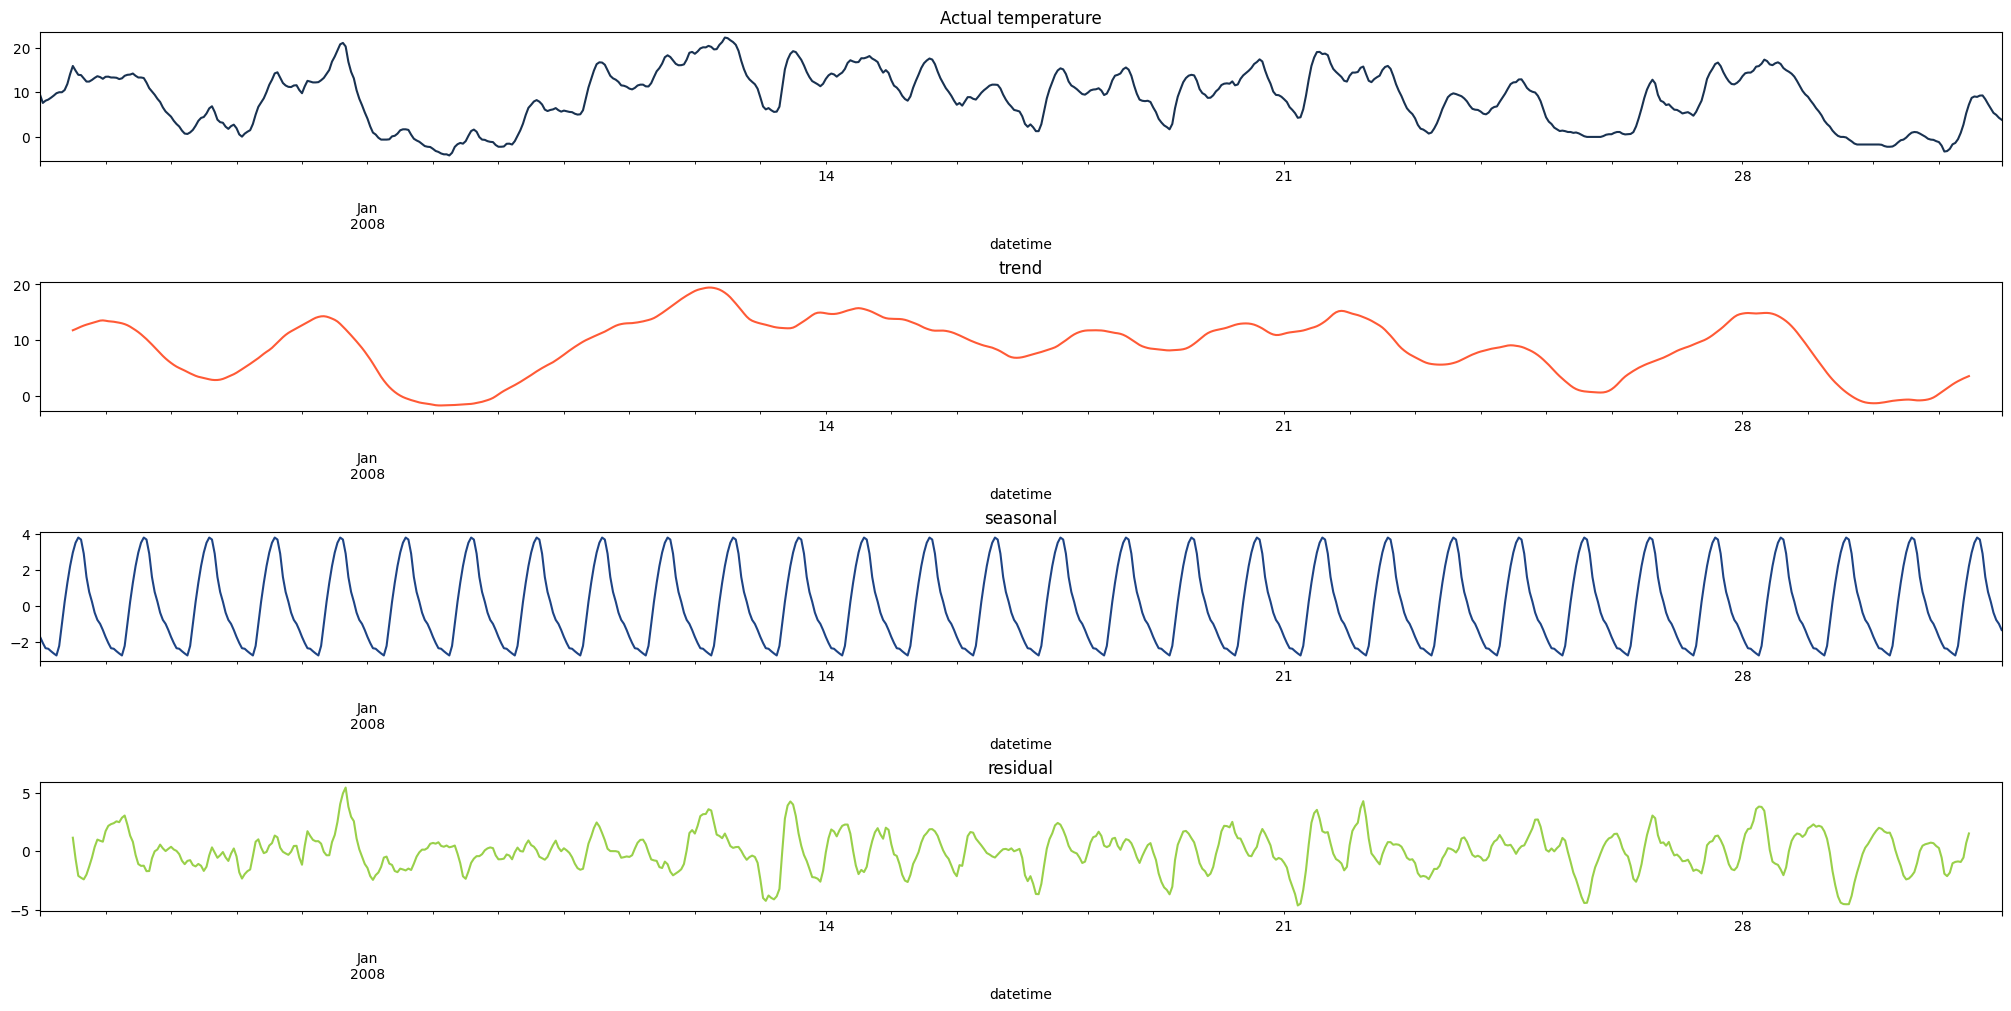

In [12]:
#decomposing daily trend
decomposition_dailyseason = seasonal_decompose(x=b5.outdoor_drybulb_temp_C.head(24*30), 
                                   model='additive',
                                   period=24)
plot_decomposition(decomposition_dailyseason)


In [13]:
##decomposing multiple seasonalities
##this requires the development version of statsmodels
##and it produces weird results.
#
##https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
##https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stl/mstl.html
##https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530
##from statsmodels.tsa.seasonal import DecomposeResult
#from statsmodels.tsa.stl.mstl import MSTL
#
#mstl_model = MSTL(b5.loc[span("2008-01-02", "2010-05-05"), "outdoor_drybulb_temp_C"], periods=(24 * 365, 24))
#res = mstl_model.fit()
#ax = res.plot()

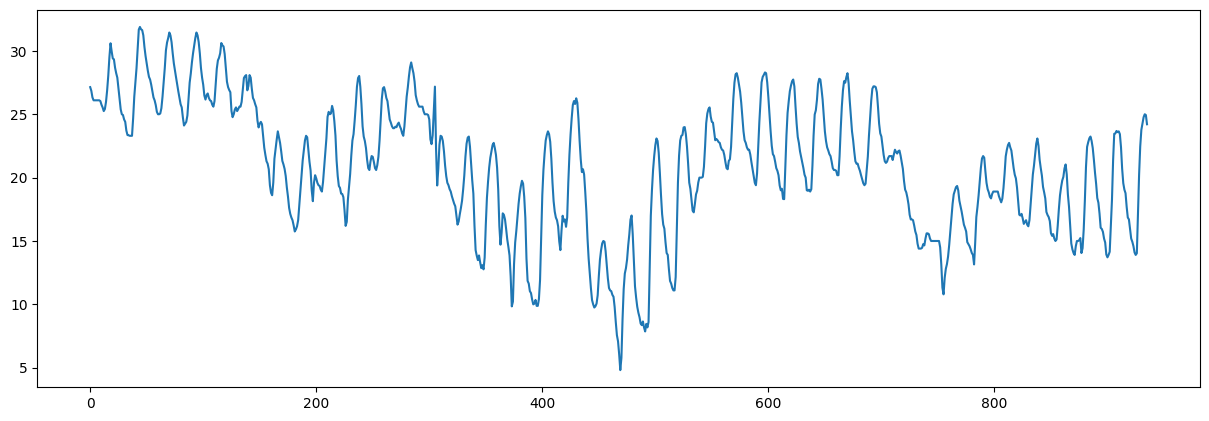

In [14]:
plt.plot(b5.tail(2000).head(24*39).outdoor_drybulb_temp_C.values)

/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


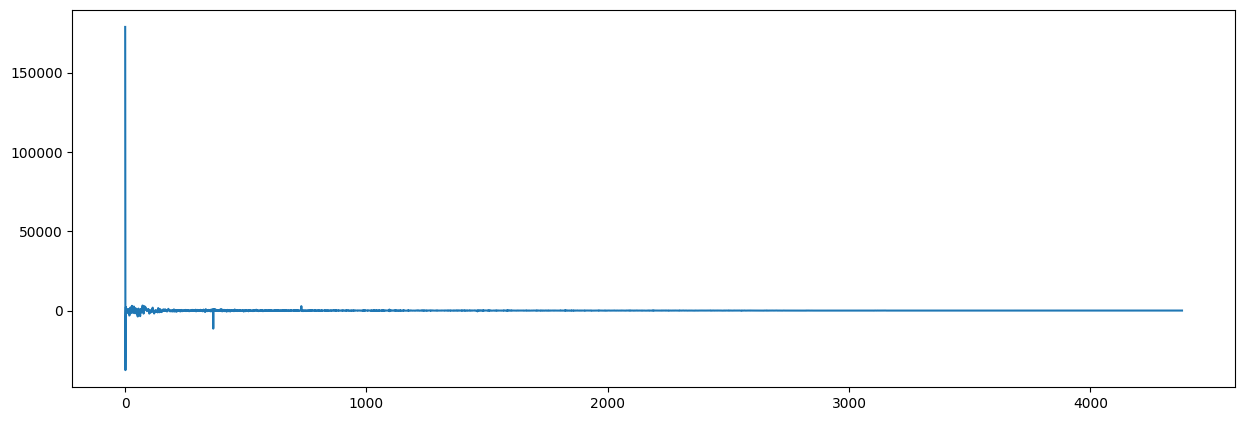

In [15]:
sp = np.fft.rfft(b5.head(24*365).outdoor_drybulb_temp_C.values)
#freq = np.fft.fftfreq(24*365*2)
plt.plot(sp)

In [16]:
#import statsmodels.api as sm
#model = sm.tsa.UnobservedComponents(b5.head(24*365).outdoor_drybulb_temp_C.values,
#                                    level='fixed intercept',
#                                    freq_seasonal=[{'period': 24},
#                                                   {'period': 24*365
#                                    }])
#res_f = model.fit(disp=False)
#print(res_f.summary())
## The first state variable holds our estimate of the intercept
#print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))
#
#res_f.plot_components()
#plt.show()

In [17]:
#b5[b5.month < 4 or b5.month > 9]
is_winter = np.logical_or(b5.index.month < 4, b5.index.month > 9)
winterdays = b5[is_winter]
summerdays = b5[np.logical_not(is_winter)]
print(winterdays.agg("mean")["solar_generation_W_kW"])
print(summerdays.agg("mean")["solar_generation_W_kW"])

156.48278768797505
189.55362431020606


In [18]:
#how does one query for properties of the datetime index?
#b5.query("datetime.dt.hour < 5")